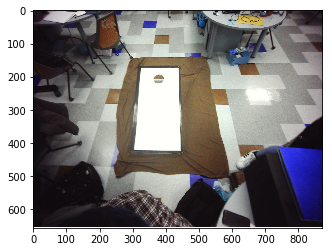

In [1]:
# Find edges

import imutils
import cv2 as cv
import numpy as np
import random as rng
from scipy.spatial import distance

from matplotlib import pyplot as plt
%matplotlib inline
#src = cv.imread('images/test_wood_bags.png')
imgString = 'testpics/t2.png'
src = cv.imread(imgString)
graysrc = cv.cvtColor(src.copy(), cv.COLOR_BGR2GRAY)
plt.imshow(src)

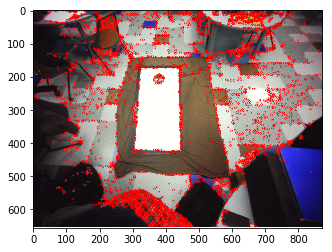

In [2]:
# Fast Detection (Optimal for resource limited devices)
fast = cv.FastFeatureDetector_create()

kp = fast.detect(src, None)
fast_src = cv.drawKeypoints(src, kp, None, color=(255,0,0))
plt.imshow(fast_src)

(255.0, 0.0, 0.0, 0.0)


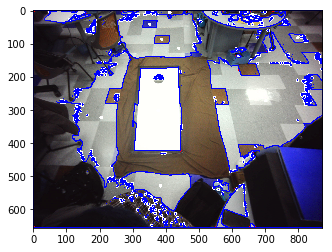

In [4]:

# convert to binary image
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Many Moments
for c in contours:
    M = cv.moments(c)
    
    if (M['m00'] != 0):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    else:
        cx, cy = 0,0
        
    cv.circle(src, (cx,cy),5, (255,255,255), -1)
        
#src2 = cv.imread('images/srcimg.png')
#for i in range(cx):
#    cv.circle(src2, (cx_arr[i],cx_arr[i]),3, 255, -1)
    
# Draw all contours
cv.drawContours(src, contours, -1, (0,0,255), 2)
    
plt.imshow(src)

# Find largest contour in image (todo)
# Find angle at which object is directed
#      ^ -- (x,y),(MA,ma),angle = cv.fitEllipse(cnt)
mask = np.zeros(graysrc.shape, np.uint8)
cv.drawContours(mask, contours, 0,255,-1)

cnt = contours[0]
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmin()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmin()][0])

extreme_pts = [leftmost, rightmost, topmost, bottommost]
for i in range(len(extreme_pts)):
    cv.circle(src, (extreme_pts[i][0],extreme_pts[i][1]), 3, 255, -1)
    
    
mean_val = cv.mean(src, mask=mask)
print(mean_val)


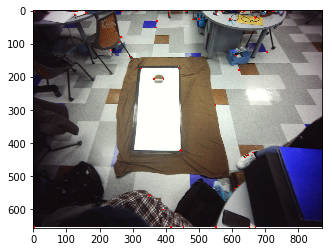

In [3]:
# Good Feature Detection (finds corners well)
corners = cv.goodFeaturesToTrack(graysrc, 50, 0.01, 10)
corners = np.int0(corners)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv.circle(src,(x,y),3,255,-1)

plt.imshow(src)

In [5]:
# Utility functions for dealing with contours
def get_cnt_details(cnt):
    M = cv.moments(cnt)
    details = None
    
    if (M['m00'] != 0):
        details = {}
        details['cx'] = cx = int(M['m10']/M['m00'])
        details['cy'] = cy = int(M['m01']/M['m00'])
        details['area'] = area = cv.contourArea(cnt)
        details['perimeter'] = perimeter = cv.arcLength(cnt,True)

    return details

def print_cnt_details(cnt):
    cnt_dict = get_cnt_details(cnt)
    
    if (cnt_dict is None):
        return
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']

    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter)

    

All contours: 
cx:  251 	cy:  262 	area:  215.0 	perimeter:  83.5979790687561 	contourLength:  72
cx:  247 	cy:  270 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  251 	cy:  267 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  255 	cy:  263 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  250 	cy:  263 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  251 	cy:  260 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  249 	cy:  260 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  250 	cy:  259 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  249 	cy:  258 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  247 	cy:  256 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  257 	cy:  255 	area:  2.0 	perimeter:  5.656854152679443 	contourLength:  4
cx:  249 	cy:  255 	area:  8.5 	perimeter:  11.899494767189026 	contourLength:  9
cx:  256 	

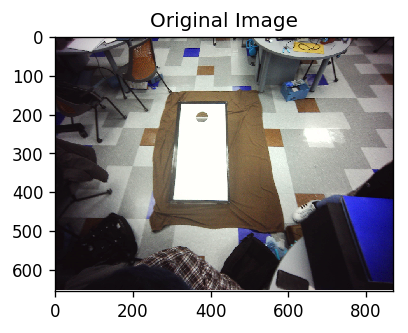

<Figure size 960x960 with 0 Axes>

In [6]:
# This block will print all contours' locations, areas, and perimters

# Define globals
board_cnt = None
board_cx = board_cy = None

# Empirically derived constants:
wood_perimeter_range = range(450, 550) # fuck this depends on distance

# Start over by reloading images
src = cv.imread(imgString)
graysrc = cv.cvtColor(src.copy(), cv.COLOR_BGR2GRAY)

# Plot original image
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(src)
a.set_title('Original Image')

# convert to binary image
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

print('All contours: ')
src_with_contours = src.copy()
possible_bag_cnts = []
for cnt in contours:
    cnt_dict = get_cnt_details(cnt)
    if (cnt_dict is None):
        continue
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']

    if (cx not in range(220,350) or cy not in range(140, 300)):
        continue
    elif (perimeter > 25 and perimeter < 80):
        possible_bag_cnts.append(cnt)
    area = cv.contourArea(cnt)
    perimeter = cv.arcLength(cnt,True)
    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter, '\tcontourLength: ', len(cnt))
    
    # draw all of the contours we find
    cv.drawContours(src_with_contours, cnt, -1, (0,0,255), 2)

    if (int(area) in range(1000, 2000)): # must convert double to int for range comparison
        # save board contour and centroid (x,y) values
        board_cnt = cnt; board_cx = cx; board_cy = cy
        
print('\n')

fig = plt.figure(figsize=(8,8),dpi=(120))

if (board_cnt is not None):
        
    # Get mask
    mask = np.zeros(graysrc.shape,np.uint8)
    cv.drawContours(mask,[board_cnt],0,255,cv.FILLED)
    
    # Get all the pixels of the board
    pixelpoints = np.transpose(np.nonzero(mask))
    
    # Display subplot showing board mask
    a = fig.add_subplot(2,2,1)
    plt.imshow(mask)
    a.set_title('Board Mask')

    # Get the color at the centroid of the board
    board_centroid_rgb = [src.item(board_cx,board_cy,rgb) for rgb in range(0,3)]
    print("RGB: ", board_centroid_rgb)
    
    # Fill the board contour with some specific color
    print('mean color: ', cv.mean(src, mask=mask))
    board_color_mean = cv.mean(src, mask=mask)
    cloned = cv.drawContours(src.copy(), [board_cnt], 0, board_centroid_rgb, cv.FILLED)

    # Display subplot filling in board mask with centroid RGB
    a = fig.add_subplot(2,2,2)
    plt.imshow(cloned)
    a.set_title('Board filled with centroid RGB')


1
AREA: {det['area']}
RED: {num_red}
BLACK: {num_black}


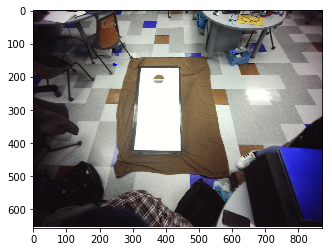

In [7]:
# Show contours with area greater than 10 and less than 150 within the masked region

bag_cnts_img = cv.drawContours(src.copy(), possible_bag_cnts, -1, (0,0,255), 2)
plt.imshow(bag_cnts_img)
print(len(possible_bag_cnts))

num_red = 0
num_black = 0
for idx,cnt in possible_bag_cnts:
    det = get_cnt_details(cnt)
    print("AREA: {det['area']}") 
    if (det['area'] > 100):
        num_black += 1
    else:
        num_red += 1
        
print('RED: {num_red}')
print('BLACK: {num_black}')

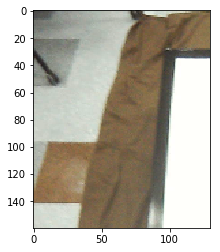

In [8]:
# Crop images

import operator 

def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

def crop_center(img,cropx,cropy):
    (y,x,_) = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

crop = src[140:300,220:350]
plt.imshow(crop)

num_red:  0 	num_black:  0


Text(0.5, 1.0, 'Contours in Masked Image')

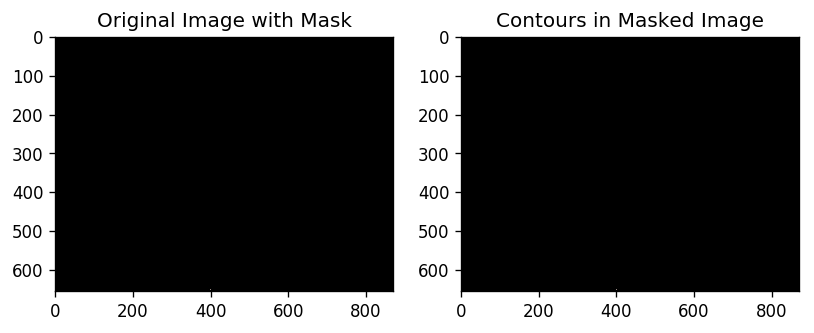

In [9]:
# Count the number of bags of each color within the board


def get_ishness(rgb):
    #h,s,v = rgb_to_hsv(r,g,b) #h from 0-360, s and v from 0-100
    rgba = [int(rgb[0]), int(rgb[1]), int(rgb[2])]
    hsv = cv.cvtColor(rgba, cv.COLOR_BGR2HSV)
    h = hsv[0]
    s = hsv[1]
    v = hsv[2]
    
    if v < 50: return 'black'
    if s < 15: return None
    if h < 10: return 'red'
    if 80 < h < 100: return 'green'
    if 210 < h < 230: return 'blue'
    
    return None

#new_image = cv2.drawContours(mask,[c], -1, (255,255,255), -1)
#new_image_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
#ret, thresh1 = cv2.threshold(new_image_gray, 100, 255, cv2.THRESH_BINARY)
masked_img = cv.bitwise_and(src.copy(), src, mask=mask)

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(masked_img)
a.set_title('Original Image with Mask')

# Find contours in masked image
graysrc = cv.cvtColor(masked_img, cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh.copy(),cv.RETR_TREE, 1)

RED      = (255,0,0)
BLACK     = (0,0,255)
num_red  = 0
num_black = 0
for cnt in contours:
    d = get_cnt_details(cnt)
    
    if (d is None):
        continue
        
    if (int(d['perimeter']) in range(50,80)):
        print_cnt_details(cnt)
        cv.drawContours(masked_img, [cnt], 0, (0,0,255), cv.LINE_4)
        cnt_rgb = [src.item(d['cx'],d['cy'],rgb) for rgb in range(0,3)]
        print(cnt_rgb, '\n')
        ham_red   = distance.hamming(cnt_rgb[0:3], RED)
        ham_black = distance.hamming(cnt_rgb[0:3], BLACK)
        
        color = get_ishness(cnt_rgb)
        
        if (color == 'red'): num_red = num_red + 1
        elif (color == 'black'): num_black = num_black + 1
        
        
        if ( ham_red < ham_black ):
            num_red = num_red + 1
        else:
            num_black = num_black + 1
        
        

        
print('num_red: ', num_red, '\tnum_black: ', num_black)
    
a = fig.add_subplot(1,2,2)
plt.imshow(masked_img)
a.set_title('Contours in Masked Image')


original board: 


best contour: 
cx:  144 	cy:  44 	area:  6048.5 	perimeter:  350.06601536273956


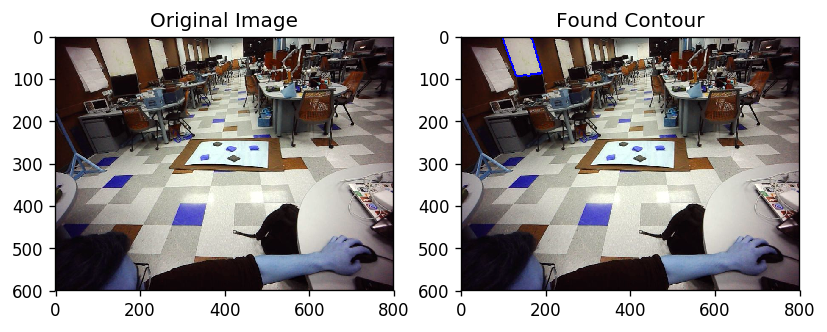

In [10]:
# Try to find the board based on the color we identified at its centroid
src = cv.imread('images/test_wood_bags.png')
graysrc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# RGB at centroid of board, found empirically in a prior experiment
board_rgb = [182, 179, 164]

# Iterate through all the contours and save the one with the average color closest to that of ours
best_ham = np.inf
best_cnt = None
for cnt in contours:
    
    cnt_dict = get_cnt_details(cnt)
    
    if((cnt_dict) is None):
        continue
        
    # Get mask for the current contour
    mask = np.zeros(graysrc.shape,np.uint8)
    cv.drawContours(mask,[cnt],0,255,cv.FILLED)

    # get the mean color for the current contour, using the current mask
    curr_mean = cv.mean(src, mask=mask)

    # save the contour with mean RGB corresponding to smallest hamming distance from target RGB
    if (distance.hamming(curr_mean[0:3], board_rgb) < best_ham):
        best_cnt = cnt
            
if (best_cnt is not None):
    
    print('original board: ')
    print_cnt_details(board_cnt)
    
    print('\n')
    
    print('best contour: ')
    print_cnt_details(best_cnt)
    
    fig = plt.figure(figsize=(8,8),dpi=(120))
    a = fig.add_subplot(1,2,1)
    a.set_title('Original Image')
    plt.imshow(src)
    
    cv.drawContours(src, [best_cnt], 0, (0,0,255), cv.LINE_4)
    a = fig.add_subplot(1,2,2)
    a.set_title('Found Contour')
    plt.imshow(src)


    